<a href="https://colab.research.google.com/github/AkritRihal/Anilata-AB-Assignment/blob/main/Human_Action_Classification_LRCNN_(CNN%2BLSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar


--2024-08-22 09:13:17--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  31.3MB/s    in 99s     

2024-08-22 09:14:56 (31.1 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [ ]:
#extract
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

In [ ]:
all_classes_names = os.listdir('UCF50')
all_classes_names


['Billiards',
 'PommelHorse',
 'RopeClimbing',
 'Diving',
 'SalsaSpin',
 'JugglingBalls',
 'JavelinThrow',
 'Basketball',
 'JumpRope',
 'Skijet',
 'HighJump',
 'TaiChi',
 'BreastStroke',
 'GolfSwing',
 'Lunges',
 'SkateBoarding',
 'HorseRiding',
 'RockClimbingIndoor',
 'MilitaryParade',
 'Rowing',
 'PlayingGuitar',
 'PlayingPiano',
 'PlayingViolin',
 'Skiing',
 'PullUps',
 'WalkingWithDog',
 'Punch',
 'HulaHoop',
 'Swing',
 'PoleVault',
 'PlayingTabla',
 'PizzaTossing',
 'Mixing',
 'Biking',
 'JumpingJack',
 'YoYo',
 'PushUps',
 'BaseballPitch',
 'CleanAndJerk',
 'Kayaking',
 'ThrowDiscus',
 'VolleyballSpiking',
 'TennisSwing',
 'Fencing',
 'Nunchucks',
 'BenchPress',
 'TrampolineJumping',
 'HorseRace',
 'SoccerJuggling',
 'Drumming']

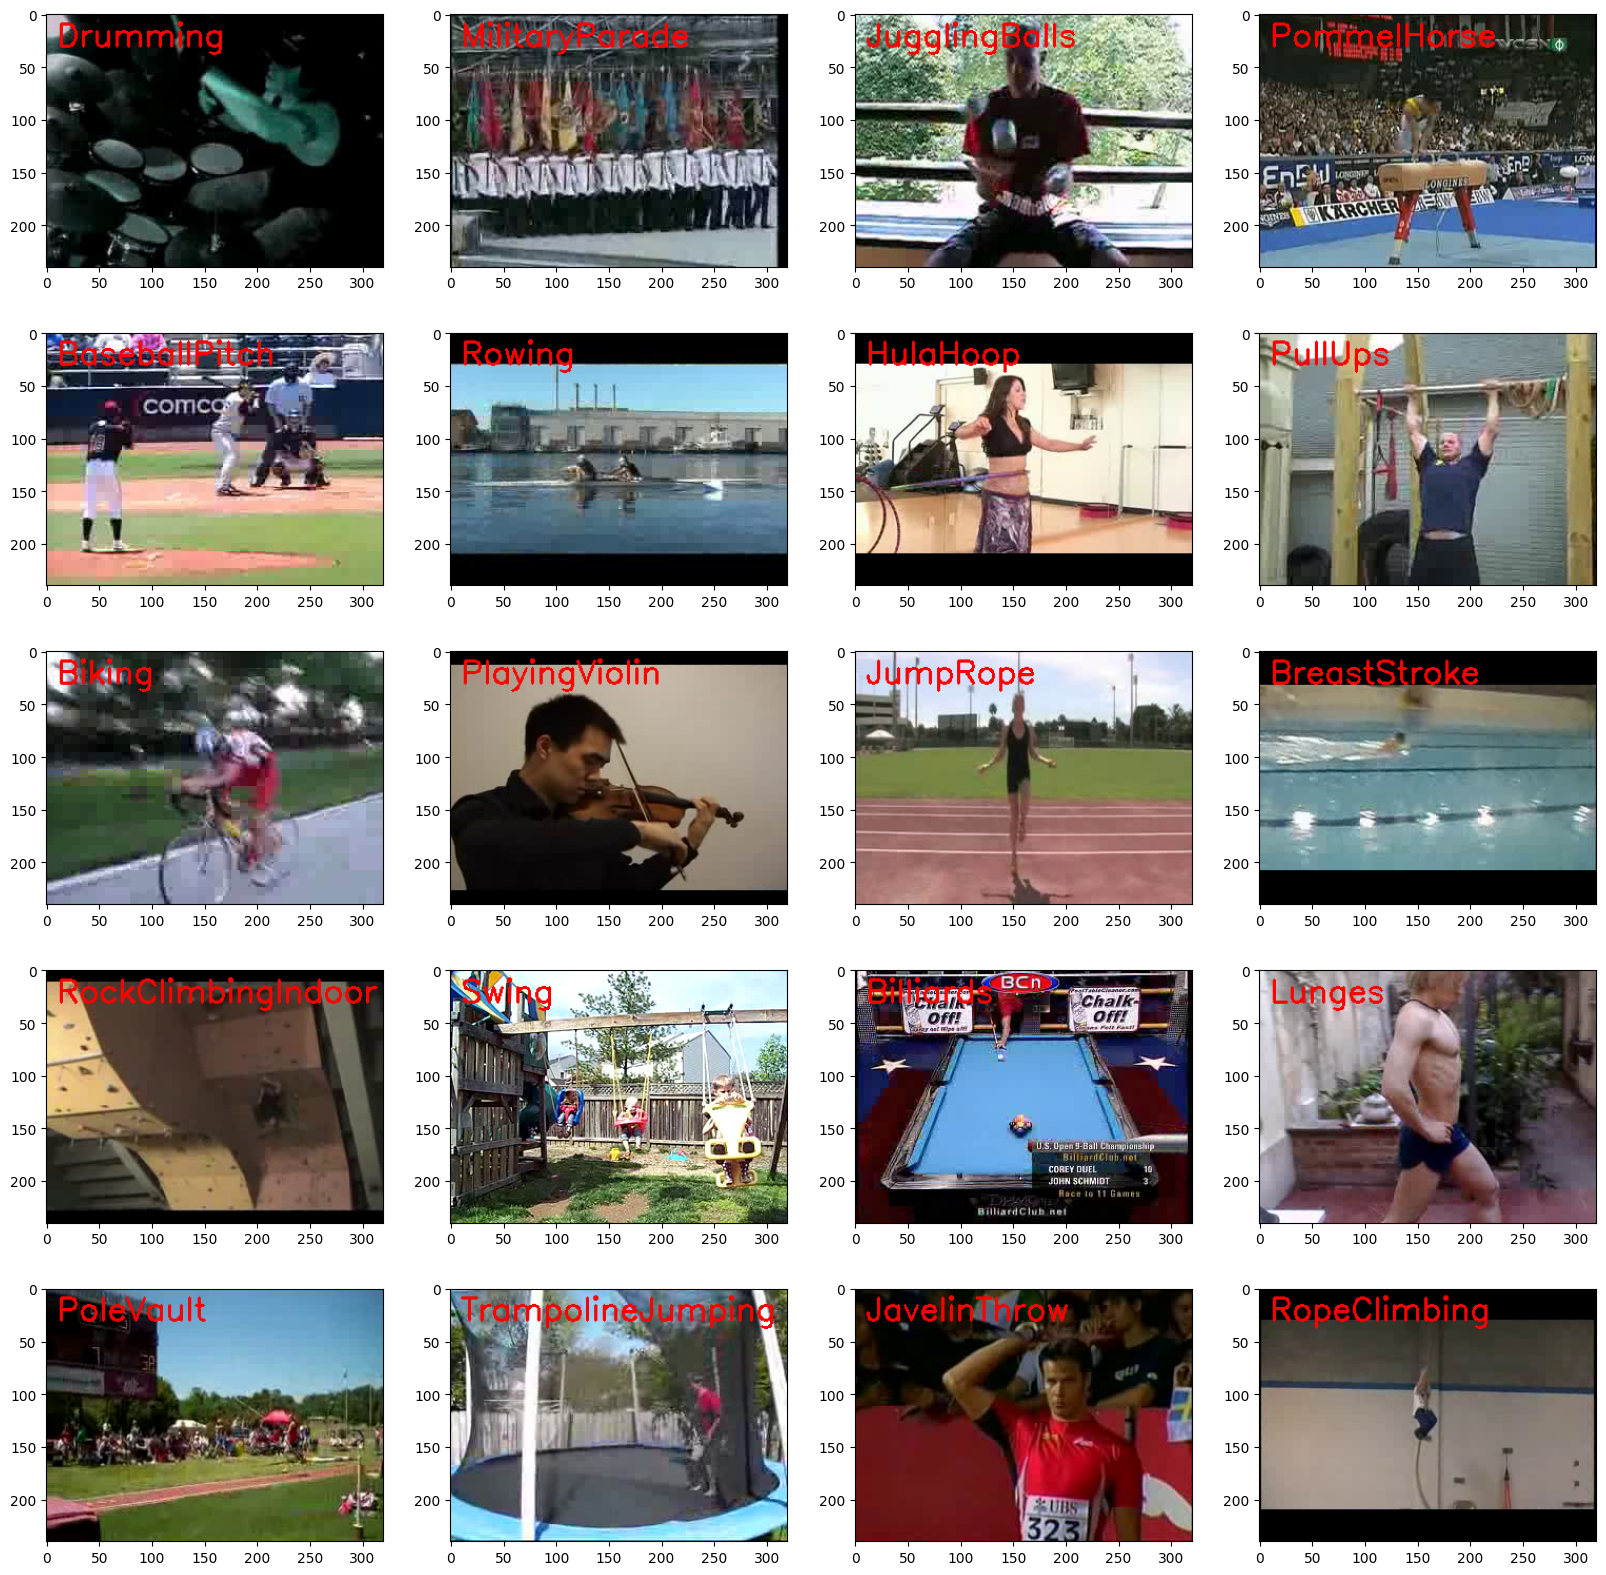

In [ ]:
#create a matplotlib figure and specify the size
plt.figure(figsize = (20, 20))

# name of all classes
all_classes_names = os.listdir('UCF50')

#iterate
random_range = random.sample(range(len(all_classes_names)), 20)
for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    #get the list of all the video files present in the randomly selected class
    video_files_names_list = os.listdir('UCF50/' + selected_class_Name)
    #randomly select a video file from the list
    selected_video_file_name = random.choice(video_files_names_list)
    #read the video
    video_reader = cv2.VideoCapture('UCF50/' + selected_class_Name + '/' + selected_video_file_name)
    #read the first frame of the video
    _, bgr_frame = video_reader.read()
    #convert the frame from BGR into RGB format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    # video frame with classname
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    #plot the frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)


In [ ]:
# preprocess data
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [ ]:
# extract resize, normalize
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  # iterate through video frames
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()
  return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()


Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [ ]:
one_hot_encoded_labels = to_categorical(labels)
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)
# Print the Number of Training and Test Examples.
print("Number of training examples :", features_train.shape[0])
print("Number of testing examples :", features_test.shape[0])

Number of training examples : 365
Number of testing examples : 122


In [ ]:
def create_LRCN_model():


    model = Sequential()

    # Define the Model Architecture.

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    model.summary()

    return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 4, 4, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 2, 2, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.2517 - loss: 1.4047 - val_accuracy: 0.3836 - val_loss: 1.3463
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.4062 - loss: 1.2866 - val_accuracy: 0.4110 - val_loss: 1.2729
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.4776 - loss: 1.1507 - val_accuracy: 0.4521 - val_loss: 1.1879
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5818 - loss: 1.0093 - val_accuracy: 0.5205 - val_loss: 1.1252
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6434 - loss: 0.9031 - val_accuracy: 0.5753 - val_loss: 0.9899
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6895 - loss: 0.7753 - val_accuracy: 0.5753 - val_loss: 0.9597
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7496 - loss: 0.7081 - val_accuracy: 0.6438 - val_loss: 0.9518
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7388 - loss: 0.6444 - val_accuracy: 0.6027 - 

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8119 - loss: 0.5207


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(1, len(metric_value_1) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metric_value_1, 'bo-', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'ro-', label=metric_name_2)

    plt.title(plot_name)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

# # Example usage
# plot_metric(history_vgg16, 'accuracy', 'val_accuracy', 'Training and Validation Accuracy')
# plot_metric(history_vgg16, 'loss', 'val_loss', 'Training and Validation Loss')


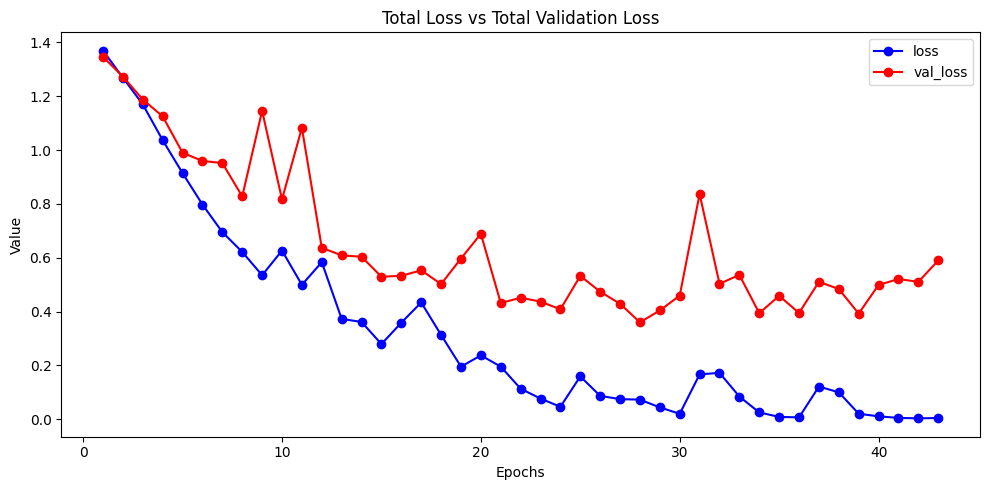

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


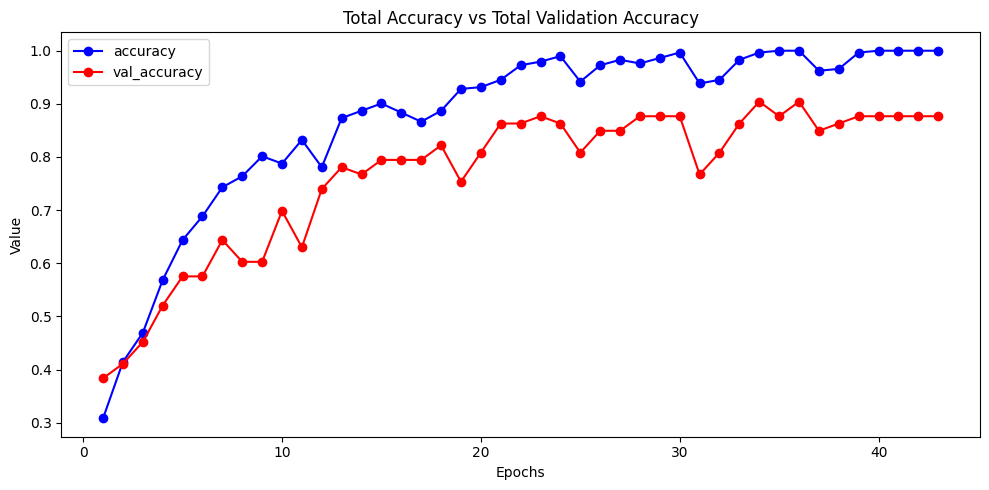

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')
